In [1]:
import math
import numpy as np
from datetime import datetime
import time

# constants
TARGET_UTILIZATION = 0.8
CURVE_STEEPNESS = 4.0
INITIAL_RATE_AT_TARGET = 0.04 / 365.0
MIN_RATE_AT_TARGET = 0.001 / 365
MAX_RATE_AT_TARGET = 2.0 / 365
ADJUSTMENT_SPEED = 50 / 365

TIME_NOW = int(datetime.now().timestamp())

# only used for sanity checks
ACCURACY = 0.001

In [2]:
class AdaptiveIRMStorage:
  def __init__(
      self,
      end_rate_at: float,
      last_update: int
  ):
    self._end_rate_at = end_rate_at
    self._last_update = last_update

  def update_rate_at_target(self, end_rate_at: float, last_update: int):
    self._end_rate_at = end_rate_at
    self._last_update = last_update

# initialize adaptive IRM storage with start rate and set timestamp
adaptive_irm_storage = AdaptiveIRMStorage(INITIAL_RATE_AT_TARGET, TIME_NOW)

In [3]:
def clamp_value(value: int, min_value: int, max_value: int):
  return max(min(value, max_value), min_value)

def test_can_correctly_clamp_value():
  # if value is in between min and max we get value
  assert clamp_value(10, 0, 100) == 10
  # if value is max we get max
  assert clamp_value(100, 0, 100) == 100
  # if value is min we get min
  assert clamp_value(0, 0, 100) == 0
  # if value is negative we get min
  assert clamp_value(-10, 0, 100) == 0
  # if value is above max we get max
  assert clamp_value(101, 0, 100) == 100

test_can_correctly_clamp_value()

In [4]:
def get_utilization(collateral: int, debt: int, mcr: int):
  """Calculate utilization.

  Args:
    collateral: Collateral in vault in USD.
    debt: Debt in vault in USD.
    mcr: Minimum collateral ratio.

  Returns:
    Utilization.
  """
  assert collateral != 0, "No collateral in vault"
  assert debt >= 0, "Negative debt is not allowed"
  assert mcr != 0, "Minimum collateral ratio must be larger zero"

  # Minimum LTV (mltv) is the inverse of the minimum collateral ratio (mcr)
  mltv = 1.0 / mcr

  # Calculate global LTV
  ltv = debt / collateral

  # Utilization
  # Clamped to the range [0, 1]
  return clamp_value(ltv / mltv, 0, 1)

def test_can_obtain_utilization_correctly():
  # each test_case:
  # (collateral, debt, mcr, wanted_scaled_ltv)
  test_cases = {
      # mcr = 1.2
      (187.5, 100, 1.2, 0.64),
      (300, 100, 1.2, 0.399),
      # mcr = 1.3
      (166, 100, 1.3, 0.783),
      (150, 100, 1.3, 0.867),
      # mcr = 1.5
      (180, 100, 1.5, 0.833),
      (200, 100, 1.5, 0.750)
  }

  for i, test_case in enumerate(test_cases):
    _collateral, _debt, _mcr, _wanted = test_case
    utilization = get_utilization(_collateral, _debt, _mcr)

    # scaled_ltv must be in bounds
    assert utilization >= 0 and utilization <= 1

    # scaled TVL must be accurate enough
    assert np.isclose(utilization, _wanted, atol=ACCURACY)

test_can_obtain_utilization_correctly()

In [5]:
def get_error_factor(utilization: float, target_utilization: float):
  """Calculate error factor.

  Args:
    utilization: Utilization.
    target_utilization: Target utilization.

  Returns:
    Error factor.
  """
  assert utilization >= 0 and utilization <= 1, "Utilization must be in range [0, 1]"
  assert target_utilization >= 0 and target_utilization <= 1, "Target utilization must be in range [0, 1]"

  # get error norm factor
  error_norm_factor = 1 - target_utilization if (utilization > target_utilization) else target_utilization

  return (utilization - target_utilization) / error_norm_factor


def test_can_obtain_error_factor_correctly():
  # each test_case:
  # (utilization, target_utilization, wanted_error_factor)
  test_cases = {
      (0.1, 0.8, -0.875),
      (0.2, 0.8, -0.750),
      (0.3, 0.8, -0.625),
      (0.4, 0.8, -0.500),
      (0.5, 0.8, -0.375),
      (0.6, 0.8, -0.250),
      (0.7, 0.8, -0.125),
      (0.8, 0.8, 0.000),
      (0.9, 0.8, 0.5),
      (1.0, 0.8, 1.0)
  }

  for i, test_case in enumerate(test_cases):
    _utilization, _target_utilization, _wanted = test_case
    error_factor = get_error_factor(_utilization, _target_utilization)

    # error factor must be accurate enough
    assert np.isclose(error_factor, _wanted, atol=ACCURACY)
test_can_obtain_error_factor_correctly()

In [6]:
def get_curve(rate_at_target: float, err: float):
  """Calculate curve.

  Args:
    rate_at_target: Rate at target utilization.
    err: Error factor.

  Returns:
    Curve.
  """
  assert rate_at_target >= 0 and rate_at_target <= 1, "Rate at target utilization must be in range [0, 1]"
  assert err >= -1 and err <= 1, "Error factor must be in range [-1, 1]"

  # Non-negative because 1 - 1/CS >= 0, CS - 1 >= 0.
  coeff = (1 - 1/CURVE_STEEPNESS) if err < 0 else CURVE_STEEPNESS - 1

  return (coeff * err + 1) * rate_at_target

def test_can_obtain_curve_correctly():
  # each test_case:
  # (rate_at_target, err, wanted_curve)
  test_cases = {
      (0.04, -0.1, 0.037),
      (0.04, 0.1, 0.052),
      (0.04, 0.5, 0.10),
      (0.04, 1.0, 0.16),
  }

  for i, test_case in enumerate(test_cases):
    _rate_at_target, _err, _wanted = test_case
    curve = get_curve(_rate_at_target, _err)

    # curve must be accurate enough
    assert np.isclose(curve, _wanted, atol=ACCURACY)

test_can_obtain_curve_correctly()

In [7]:
def new_rate_at_target(start_rate_at_target: float, linear_adaption: float):
  """Calculate new rate at target.

  Args:
    start_rate_at_target: Rate at target utilization.
    linear_adaption: Linear adaption

  Returns:
    New rate at target.
  """
  rate = start_rate_at_target * math.exp(linear_adaption)
  return clamp_value(rate, MIN_RATE_AT_TARGET, MAX_RATE_AT_TARGET)

In [8]:
def get_interest_rate(
    collateral: int,
    debt: int,
    mcr: float,
    start_rate_at_target: float,
    current_timestamp: int,
    last_timestamp: int,
  ):
  """Calculate interest rate.

  Args:
    collateral: Collateral in vault in USD.
    debt: Debt in vault in USD.
    mcr: Minimum collateral ratio.
    start_rate_at_target: Rate at target utilization.
    linear_adaption: Linear adaption
    current_timestamp: Current timestamp.
    last_timestamp: Last timestamp.

  Returns:
    New rate at target.
  """
  assert collateral != 0, "No collateral in vault"
  assert debt >= 0, "Negative debt is not allowed"
  assert mcr >= 0, "Minimum collateral ratio must be larger zero"

  # get utilization
  utilization = get_utilization(collateral, debt, mcr)
  assert utilization >= 0 and utilization <= 1, "Utilization must be in range [0, 1]"
  print(f"Utilization: {utilization}")

  # get error
  err = get_error_factor(utilization, TARGET_UTILIZATION)
  assert err >= -1 and err <= 1, "Error factor must be in range [-1, 1]"
  print(f"Error: {err}", "-> we decrease rate" if err < 0 else "-> we increase rate")

  assert start_rate_at_target >= 0 and start_rate_at_target <= 2, "Rate at target utilization must be in range [0, 2]"

  # get start rate at target
  start_rate_at_target = adaptive_irm_storage._end_rate_at

  # model exponential via trapezoid
  if start_rate_at_target == 0:
    avg_rate_at_target = INITIAL_RATE_AT_TARGET
    end_rate_at_target = INITIAL_RATE_AT_TARGET
  else:
    # create linear adaptation
    linear_adaptation = ADJUSTMENT_SPEED * err * (current_timestamp - last_timestamp)
    print(f"Last update: {last_timestamp}")
    print(f"Current timestamp: {current_timestamp}")
    print(f"Linear adaptation: {linear_adaptation}")

    if linear_adaptation == 0:
      avg_rate_at_target = start_rate_at_target
      end_rate_at_target = start_rate_at_target
    else:
      end_rate_at_target = new_rate_at_target(start_rate_at_target, linear_adaptation)
      midRateAtTarget = new_rate_at_target(start_rate_at_target, linear_adaptation / 2.0)
      avg_rate_at_target = (start_rate_at_target + end_rate_at_target + 2 * midRateAtTarget) / 4.0

  new_rate = get_curve(avg_rate_at_target, err)

  return new_rate, end_rate_at_target, current_timestamp

In [9]:
current_time = int(datetime.now().timestamp())
mcr = 1.2

step_size = 150
test_cases = [
    (400, 100, current_time + 1 * step_size),
    (350, 100, current_time + 2 * step_size),
    (230, 100, current_time + 3 * step_size),
    (180, 100, current_time + 4 * step_size),
    (170, 100, current_time + 5 * step_size),
    (164, 100, current_time + 6 * step_size),
    (153, 100, current_time + 7 * step_size),
    (153, 100, current_time + 8 * step_size),
    (153, 100, current_time + 9 * step_size),
    (153, 100, current_time + 10 * step_size),
    (142, 100, current_time + 11 * step_size),
    (132, 100, current_time + 12 * step_size),
    (122, 100, current_time + 13 * step_size),
    (112, 100, current_time + 14 * step_size),
    (112, 100, current_time + 15 * step_size),
    (112, 100, current_time + 16 * step_size),
    (122, 100, current_time + 17 * step_size),
    (128, 100, current_time + 18 * step_size),
    (132, 100, current_time + 19 * step_size),
    (136, 100, current_time + 20 * step_size),
    (143, 100, current_time + 21 * step_size),
    (149, 100, current_time + 22 * step_size),
    (159, 100, current_time + 23 * step_size),
]

# cache initial state of adaptive IRM model
initial_rate = 0.04
adaptive_irm_storage.update_rate_at_target(initial_rate, current_time)
print(f"Initial rate: {adaptive_irm_storage._end_rate_at}")
print(f"Minimum collateral ratio: {mcr}")
print('-' * 50)

data = [[0, initial_rate]]

i = 1
for test_case in test_cases:
  _collateral, _debt, _current_time = test_case
  print(f"Step {i}")
  print(f"Collateral in USD: {_collateral}")
  print(f"Debt in USD: {_debt}")
  new_rate, end_rate, timestamp = get_interest_rate(_collateral, _debt, mcr, adaptive_irm_storage._end_rate_at, _current_time, adaptive_irm_storage._last_update)
  adaptive_irm_storage.update_rate_at_target(new_rate, timestamp)
  initial_rate = new_rate
  print(f"Cached rate: {adaptive_irm_storage._end_rate_at}")
  print(f"Last updated: {adaptive_irm_storage._last_update}")
  print('-' * 50)
  data.append([i, new_rate])
  i += 1


Initial rate: 0.04
Minimum collateral ratio: 1.2
--------------------------------------------------
Step 1
Collateral in USD: 400
Debt in USD: 100
Utilization: 0.3
Error: -0.625 -> we decrease rate
Last update: 1740581873
Current timestamp: 1740582023
Linear adaptation: -12.842465753424657
Cached rate: 0.005330147021222348
Last updated: 1740582023
--------------------------------------------------
Step 2
Collateral in USD: 350
Debt in USD: 100
Utilization: 0.3428571428571428
Error: -0.5714285714285715 -> we decrease rate
Last update: 1740582023
Current timestamp: 1740582173
Linear adaptation: -11.741682974559689
Cached rate: 0.0007661362992994042
Last updated: 1740582173
--------------------------------------------------
Step 3
Collateral in USD: 230
Debt in USD: 100
Utilization: 0.5217391304347826
Error: -0.3478260869565218 -> we decrease rate
Last update: 1740582173
Current timestamp: 1740582323
Linear adaptation: -7.14711137581894
Cached rate: 0.00015001859538825858
Last updated: 17

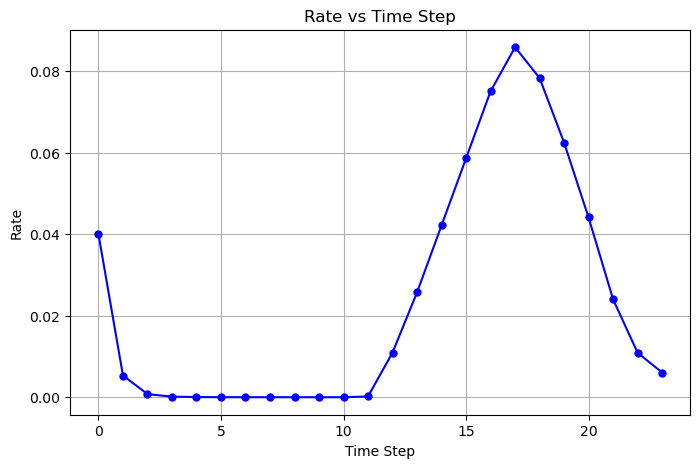

In [10]:
import matplotlib.pyplot as plt

# Extract timesteps and rates
timesteps = [item[0] for item in data]
rates = [item[1] for item in data]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(timesteps, rates, marker='o', linestyle='-', color='b', markersize=5)
plt.xlabel("Time Step")
plt.ylabel("Rate")
plt.title("Rate vs Time Step")
plt.grid(True)
plt.show()
